# Feature Selection 
## - Automated Feature Selection
## - PCA 

### All major airlines in 2019

In [1]:
#!pip install autofeatselect
#!pip install lazypredict


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from autofeatselect import CorrelationCalculator, FeatureSelector, AutoFeatureSelect
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
os.getcwd()

'/home/ccecilia'

In [4]:
n_jobs = 2 #make sure to request 2 cores
random_state = 42
seed = 24

In [5]:
df = pd.read_parquet('bts_faa_coords.parquet')

In [6]:
airlines = ['AA','AS','B6','DL','F9','HA','MQ','NK','OO','UA','WN','9E','G4','OH','YX']
#years = [2015,2016,2017,2018,2019] #two much data to run

df_2019 = df[(df['Reporting_Airline'].isin(airlines)) &
             #(df['Year'].isin(years)) &
             (df['Year']==2019) &
             (df['Cancelled']==0) &
             (df['Diverted']==0)].copy()
del df #free up memory

In [7]:
#select numeric columns
num_feats = [
    #'DepDelay', #highly correlated to the delay lable
    #'DepDelayMinutes',#highly correlated to the delay lable
   'TaxiOut',
   'TaxiIn',
   #'ArrDelay',#highly correlated to the delay lable
   #'ArrDelayMinutes',#highly correlated to the delay lable
   'AirTime',
   'Distance',
   'HORSEPOWER',
   'THRUST',
   'NO-ENG',
   'NO-SEATS',
   'SPEED',
   'Origin_LATITUDE',
   'Origin_LONGITUDE',
   'Dest_LATITUDE',
   'Dest_LONGITUDE'
]

In [8]:
cat_feats = [
    #'Year',
    'Quarter',
    'Month',
    'DayofMonth',
    'DayOfWeek',
    'Reporting_Airline',
    #'DepartureDelayGroups', #highly correlated to the delay lable
    'DepTimeBlk',
    'WheelsOff',
    'WheelsOn',
    #'ArrivalDelayGroups',#highly correlated to the delay lable
    'ArrTimeBlk',
    'CRSElapsedTime',
    'ActualElapsedTime',
    'DistanceGroup',
    'SERIAL NUMBER',
    'MFR MDL CODE',
    'ENG MFR MDL',
    'YEAR MFR',
    'TYPE REGISTRANT',
    'REGION',
    'COUNTY',
    'COUNTRY',
    'TYPE AIRCRAFT',
    'TYPE ENGINE',
    'STATUS CODE',
    'MODE S CODE',
    'FRACT OWNER',
    'AIR WORTH DATE',
    'MFR',
    'MODEL',
    'TYPE',
    'MFR_aircraft',
    'MODEL_aircraft',
    'TYPE-ACFT',
    'TYPE-ENG',
    'AC-WEIGHT'
]

In [9]:
# Convert specified columns to object type
df_2019[cat_feats] = df_2019[cat_feats].astype(str)

# Replace NaN values with empty strings
df_2019[cat_feats] = df_2019[cat_feats].fillna('')

In [10]:
# define the delay label
df_2019.loc[:, 'delay_label'] = df_2019.apply(lambda row: 1 if row['ArrDel15'] == 1 or row['DepDel15'] == 1 else 0, axis=1)

## Automated Feature Selection

In [11]:
# Split the data into a temporary training set and a holdout test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(df_2019[num_feats + cat_feats],
                                                            df_2019['delay_label'],
                                                            test_size=0.2,
                                                            random_state=random_state,
                                                            stratify=df_2019['Reporting_Airline'])

# Split the temporary training set into the final training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_temp,
                                                y_train_temp,
                                                test_size=0.2,  
                                                random_state=random_state,
                                                stratify=X_train_temp['Reporting_Airline'])
del X_train_temp #free up memory
del y_train_temp #free up memory
del df_2019 #free up memory

In [12]:
# Calculate Pearson correlation coefficient to eliminate highly related features.
corr_df_num, num_remove_list = CorrelationCalculator.numeric_correlations(X_train,
                                                                          features=num_feats,
                                                                          static_features=None,
                                                                          corr_method='pearson',
                                                                          threshold=0.8)

corr_df_cat, cat_remove_list = CorrelationCalculator.categorical_correlations(X_train,
                                                                              features=cat_feats,
                                                                              static_features=None,
                                                                              threshold=0.8)

In [13]:
num_remove_list

['AirTime']

In [14]:
cat_remove_list

['Quarter',
 'Reporting_Airline',
 'MFR MDL CODE',
 'ENG MFR MDL',
 'YEAR MFR',
 'TYPE REGISTRANT',
 'REGION',
 'COUNTY',
 'COUNTRY',
 'TYPE AIRCRAFT',
 'TYPE ENGINE',
 'STATUS CODE',
 'SERIAL NUMBER',
 'FRACT OWNER',
 'AIR WORTH DATE',
 'MFR',
 'MODEL',
 'TYPE',
 'MFR_aircraft',
 'MODEL_aircraft',
 'TYPE-ACFT',
 'TYPE-ENG',
 'AC-WEIGHT']

In [15]:
#Remove correlated features
num_feats_final = [c for c in num_feats if c not in num_remove_list]
cat_feats_final = [c for c in cat_feats if c not in cat_remove_list]

In [16]:
#Create Feature Selector Object
feat_selector = FeatureSelector(modeling_type = 'classification',
                                X_train = X_train, 
                                y_train = y_train,
                                X_test = X_test, 
                                y_test = y_test,
                                numeric_columns = num_feats_final,
                                categorical_columns = cat_feats_final,
                                seed = seed)

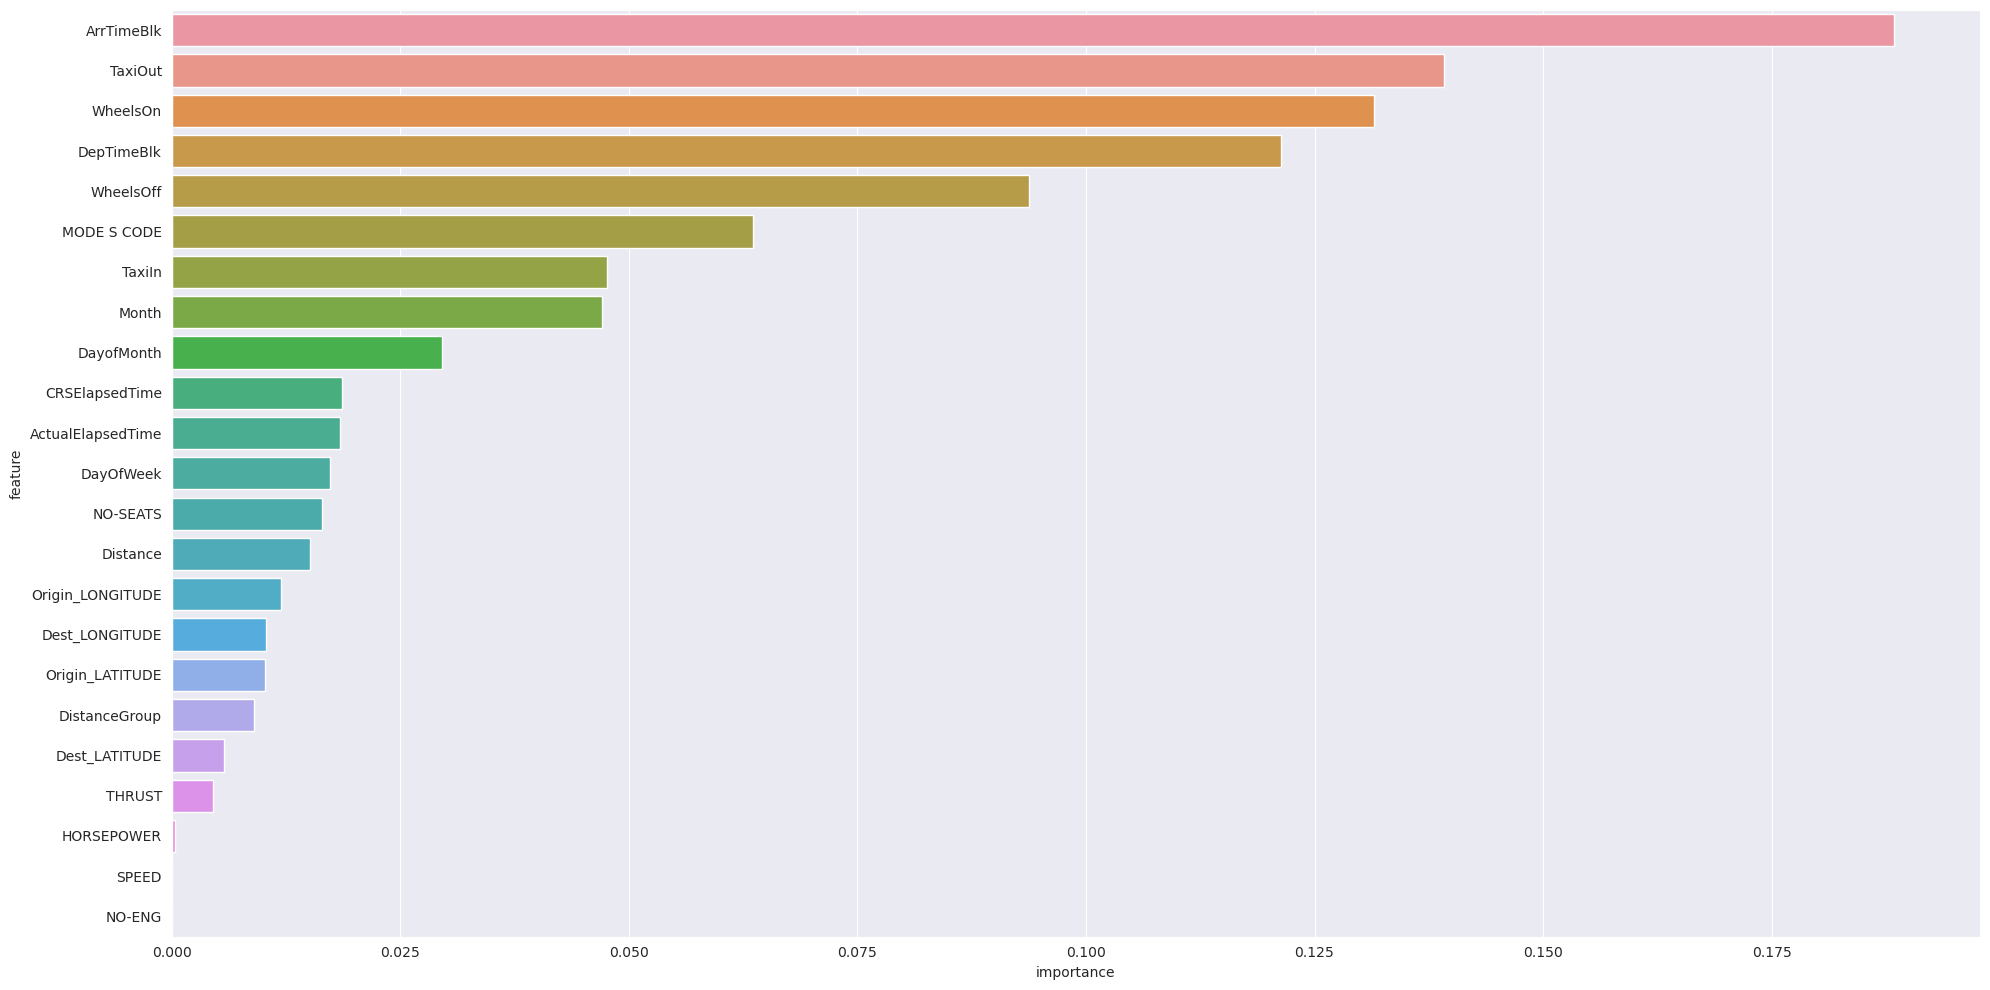

In [17]:
#XGBoost
xgb_importance_df = feat_selector.xgb_importance(hyperparam_dict = {'n_jobs':n_jobs, 'random_state':random_state},
                                                   objective = None,
                                                   return_plot = True
                                                  )

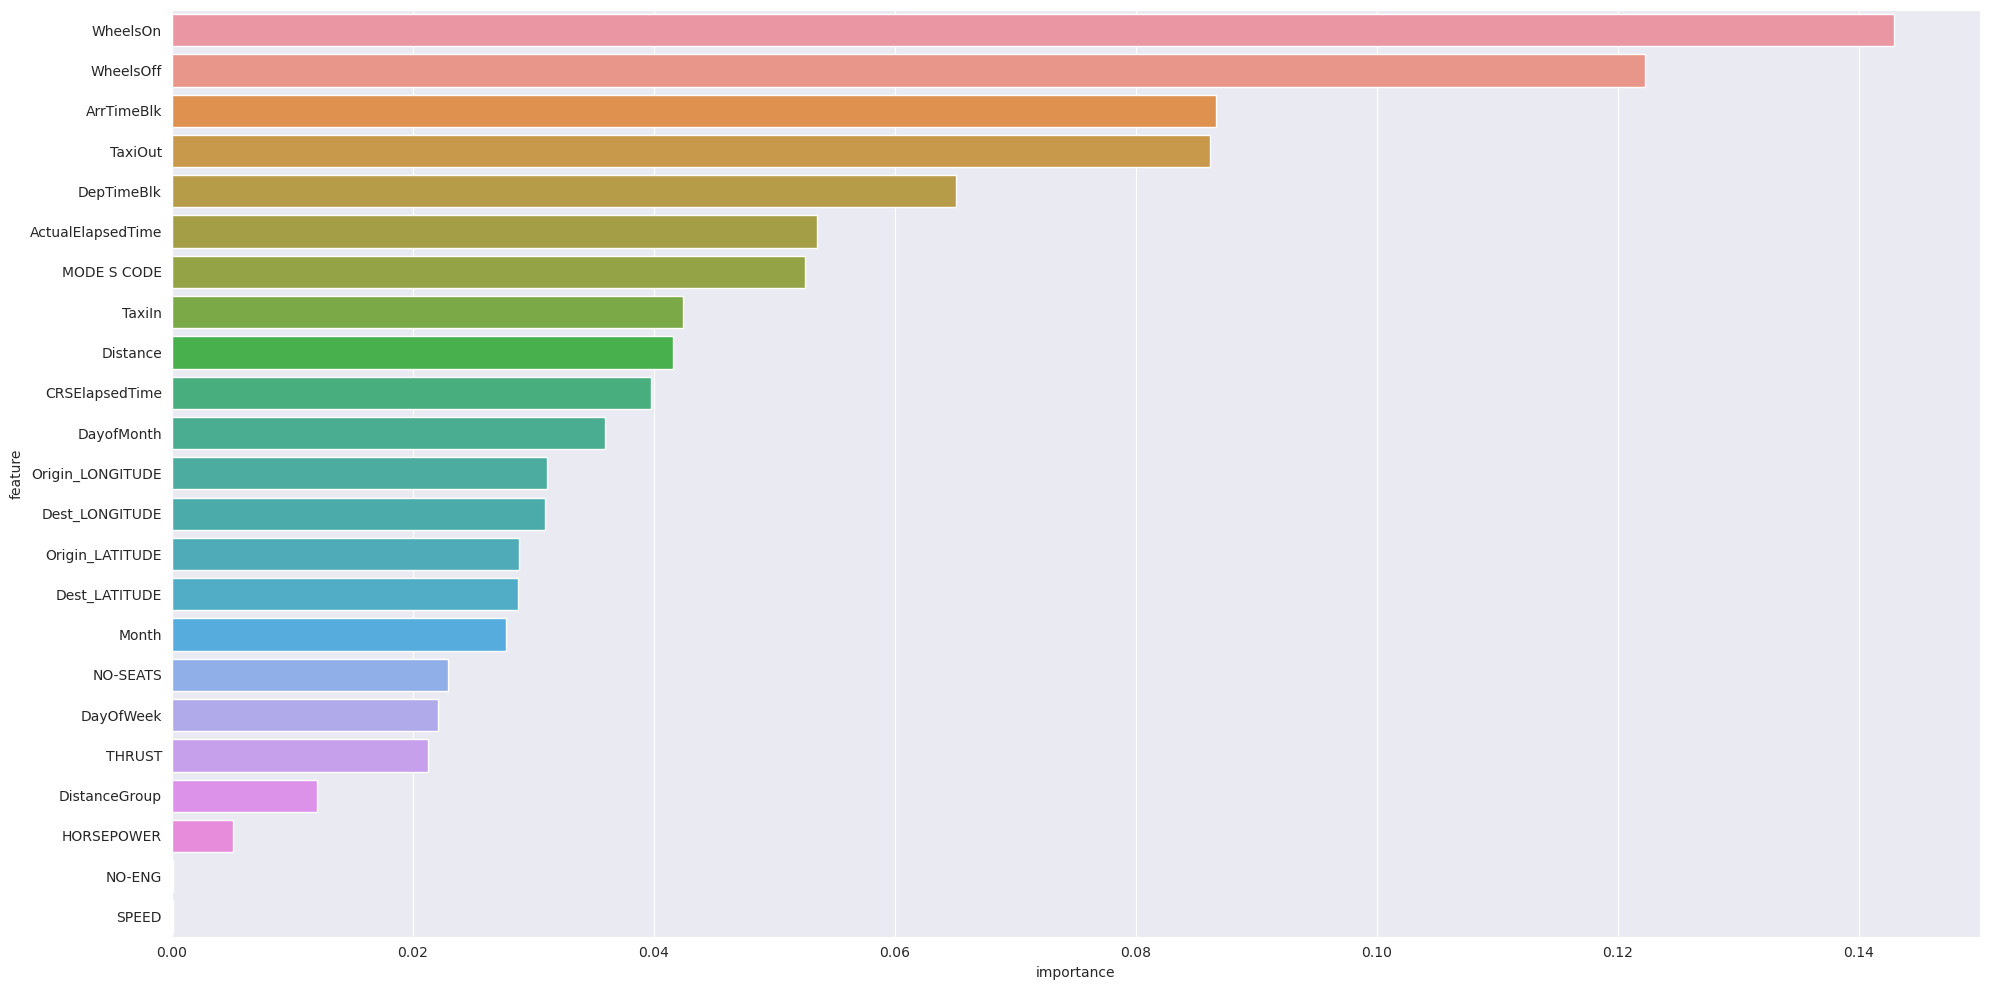

In [18]:
# Random Forest
rf_importance_df = feat_selector.rf_importance(hyperparam_dict={'n_jobs':n_jobs, 
                                                                'random_state':random_state,
                                                                
                                                               },
                                               return_plot=True
                                              )

In [19]:
xgb_importance_df.to_csv('xgb_importance.csv', index=False)
rf_importance_df.to_csv('rf_importance.csv', index=False)


In [20]:
# Find the top 10 important features in each dataframe
top_10_xgb = xgb_importance_df.nlargest(10, 'importance')
top_10_rf = rf_importance_df.nlargest(10, 'importance')


# Identify overlapping features
final_features = top_10_xgb.merge(top_10_rf, on='feature', how='inner').rename(columns={'importance_x': 'xgb_importance', 'importance_y': 'rf_importance'})

final_features.to_csv('final_features.csv', index=False)
final_features

,feature,xgb_importance,rf_importance
0,ArrTimeBlk,0.19,0.09
1,TaxiOut,0.14,0.09
2,WheelsOn,0.13,0.14
3,DepTimeBlk,0.12,0.07
4,WheelsOff,0.09,0.12
5,MODE S CODE,0.06,0.05
6,TaxiIn,0.05,0.04
7,CRSElapsedTime,0.02,0.04


### Validate the selected features by applying them to supervised learning algorithms

#### Apply Lazy Classifier from Lazy Predict to test the outcome of the feature selection process. 

In [21]:
#final_features = pd.read_csv('final_features.csv')

In [22]:
col_final = final_features['feature']

In [23]:
def labe_encoder(df):
    label_encoder = LabelEncoder()
    # Separate numeric and object columns
    object_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
    for c in object_columns:
        df[c] = label_encoder.fit_transform(df[c])
    return df

In [24]:
X_train = labe_encoder(X_train)
X_val = labe_encoder(X_val)
X_test = labe_encoder(X_test)

In [25]:
for index, c in enumerate(lazypredict.Supervised.CLASSIFIERS):
    print(f'Index {index}: {c}')

Index 0: ('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>)
Index 1: ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>)
Index 2: ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>)
Index 3: ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>)
Index 4: ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>)
Index 5: ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>)
Index 6: ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>)
Index 7: ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>)
Index 8: ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>)
Index 9: ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>)
Index 10: ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>)
Index 11: ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.

In [26]:
classifiers_copy = lazypredict.Supervised.CLASSIFIERS

In [27]:
lazypredict.Supervised.CLASSIFIERS = [classifiers_copy[15], classifiers_copy[21], classifiers_copy[27], classifiers_copy[28]]
lazypredict.Supervised.CLASSIFIERS

[('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
 ('XGBClassifier', xgboost.sklearn.XGBClassifier),
 ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]

In [28]:
clf = LazyClassifier(verbose=0, 
                     ignore_warnings=True, 
                     custom_metric=None)
models,predictions = clf.fit(X_train[col_final], X_val[col_final], y_train, y_val)

models

 75%|███████▌  | 3/4 [37:20<11:58, 718.83s/it] 

[LightGBM] [Info] Number of positive: 1022936, number of negative: 3488108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 4511044, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226763 -> initscore=-1.226683
[LightGBM] [Info] Start training from score -1.226683


100%|██████████| 4/4 [37:49<00:00, 567.34s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.93,0.86,0.86,0.93,2209.91
XGBClassifier,0.92,0.85,0.85,0.92,23.69
LGBMClassifier,0.91,0.83,0.83,0.91,28.36
LogisticRegression,0.81,0.59,0.59,0.76,7.36


In [29]:
model_dictionary = clf.provide_models(X_train[col_final], X_val[col_final], y_train, y_val)

model_dictionary['XGBClassifier']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ArrTimeBlk', 'TaxiOut', 'WheelsOn', 'DepTimeBlk', 'WheelsOff',
       'MODE S CODE', 'TaxiIn', 'CRSElapsedTime'],
      dtype='object')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### PCA for Dimension Reduction

The PCA algorithm will be applied to the dataset that has been reduced to only 8 selected features.

In [30]:
# check variables size
#sys.getsizeof(X_train)

In [31]:
df_PCA = pd.concat([X_train[col_final], X_val[col_final], X_test[col_final]], axis=0, ignore_index=True)


#del X_train #free up memory
#del X_val #free up memory
#del X_test #free up memory

In [ ]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_PCA)

# Initialize PCA with the number of components
n_components = 4  
pca = PCA(n_components=n_components)
# Fit PCA to the standardized data
pca.fit(scaled_data)

# Transform the data into the new feature space
transformed_data = pca.transform(scaled_data)

In [38]:
transformed_data.shape

(7048508, 4)

In [33]:
# Calculate the explained variance manually
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

print("Explained Variance:", explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

Explained Variance: [0.4087772  0.1397856  0.12437364 0.12206496]
Cumulative Explained Variance: [0.4087772  0.5485628  0.67293644 0.7950014 ]


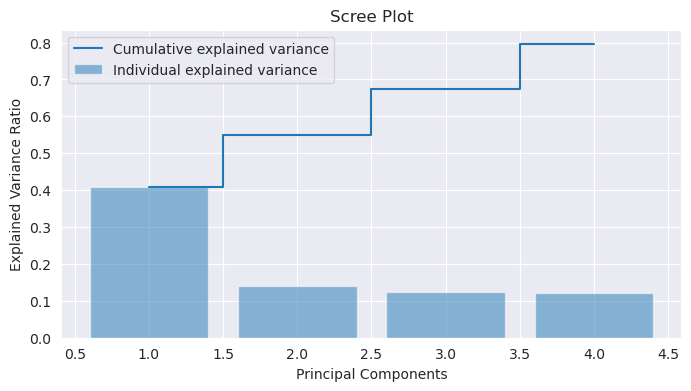

In [34]:
plt.figure(figsize=(8, 4))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, n_components + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()
